In [1]:
# Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprimir warnings TensorFlow

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# PyDMD
from pydmd import DMD

# Módulos propios
import sys
sys.path.append('../src')
from utils.metrics import evaluate_all

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')

DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../data/models')
FIG_DIR = Path('../reports/figures')
RESULTS_DIR = DATA_DIR / 'experiments'
RESULTS_DIR.mkdir(exist_ok=True)

# Verificar GPU
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"🔧 GPUs disponibles: {len(tf.config.list_physical_devices('GPU'))}")
if tf.config.list_physical_devices('GPU'):
    print(f"   GPU: {tf.config.list_physical_devices('GPU')[0].name}")

print(f"\n📁 Directorios:")
print(f"   Data: {DATA_DIR}")
print(f"   Models: {MODEL_DIR}")
print(f"   Experiments: {RESULTS_DIR}")

✅ TensorFlow version: 2.10.0
🔧 GPUs disponibles: 1
   GPU: /physical_device:GPU:0

📁 Directorios:
   Data: ..\data\processed
   Models: ..\data\models
   Experiments: ..\data\processed\experiments


## **1. Cargar Datos Base**

Reutilizar el pipeline de datos del notebook 03.

In [3]:
# Cargar datos procesados ERA5
nc_path = DATA_DIR / 'era5_precipitation_chile_full.nc'
ds = xr.open_dataset(nc_path)
ds_daily = ds.resample(valid_time='1D').sum('valid_time') * 1000  # m/día → mm/día

precip_data = ds_daily['tp'].values  # (366, 157, 41)
n_days, n_lat, n_lon = precip_data.shape

print(f"📊 Datos cargados: {precip_data.shape}")
print(f"   Días: {n_days} | Lat: {n_lat} | Lon: {n_lon}")
print(f"   Rango: [{precip_data.min():.2f}, {precip_data.max():.2f}] mm/día")
print(f"   Media: {precip_data.mean():.3f} mm/día")

📊 Datos cargados: (366, 157, 41)
   Días: 366 | Lat: 157 | Lon: 41
   Rango: [0.00, 168.72] mm/día
   Media: 2.221 mm/día


In [4]:
# Normalizar datos
precip_flat = precip_data.reshape(n_days, -1)
scaler = StandardScaler()
precip_normalized = scaler.fit_transform(precip_flat)
X = precip_normalized.reshape(n_days, n_lat, n_lon, 1)

print(f"✅ Normalización completada:")
print(f"   X shape: {X.shape}")
print(f"   X mean: {X.mean():.6f} (cercano a 0)")
print(f"   X std: {X.std():.6f} (cercano a 1)")

✅ Normalización completada:
   X shape: (366, 157, 41, 1)
   X mean: -0.000000 (cercano a 0)
   X std: 1.000000 (cercano a 1)


In [5]:
# Crear secuencias temporales
WINDOW_SIZE = 7

def create_sequences(data, window_size=7):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i+window_size])
        y_seq.append(data[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, WINDOW_SIZE)

# Split train/val/test
n_train = int(0.7 * len(X_seq))
n_val = int(0.15 * len(X_seq))

X_train = X_seq[:n_train]
y_train = y_seq[:n_train]
X_val = X_seq[n_train:n_train+n_val]
y_val = y_seq[n_train:n_train+n_val]
X_test = X_seq[n_train+n_val:]
y_test = y_seq[n_train+n_val:]

print(f"✅ Secuencias creadas:")
print(f"   Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"   Window size: {WINDOW_SIZE} días")

✅ Secuencias creadas:
   Train: (251, 7, 157, 41, 1), Val: (53, 7, 157, 41, 1), Test: (55, 7, 157, 41, 1)
   Window size: 7 días


In [16]:
# Usar loss MSE estándar (sin ponderación espacial por incompatibilidad de dimensiones)
# Los pesos espaciales de kriging tienen shape diferente a los datos ERA5
print("⚠️ Usando MSE estándar (pesos kriging incompatibles con dimensiones ERA5)")
print(f"   Pesos kriging: {spatial_weights.shape}")
print(f"   Datos ERA5: ({n_lat}, {n_lon})")

⚠️ Usando MSE estándar (pesos kriging incompatibles con dimensiones ERA5)
   Pesos kriging: (391, 101)
   Datos ERA5: (157, 41)


## **2. Función de Experimento Automatizada**

Wrapper para entrenar y evaluar modelos con diferentes configuraciones.

In [9]:
def build_autoencoder(latent_dim=64, dilations=[1,2,4,8], l2_reg=0.0001):
    """Construir autoencoder con parámetros configurables."""
    input_shape = (n_lat, n_lon, 1)
    
    # ENCODER
    encoder_input = keras.Input(shape=input_shape, name='spatial_input')
    x = encoder_input
    
    for i, dilation in enumerate(dilations):
        x = layers.Conv2D(
            filters=32,
            kernel_size=3,
            dilation_rate=dilation,
            padding='same',
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            name=f'conv{i+1}_d{dilation}'
        )(x)
    
    x = layers.Flatten()(x)
    encoded = layers.Dense(
        latent_dim,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg),
        name='latent'
    )(x)
    
    encoder = keras.Model(encoder_input, encoded, name='encoder')
    
    # DECODER
    decoder_input = keras.Input(shape=(latent_dim,), name='latent_input')
    x = layers.Dense(
        n_lat * n_lon,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg)
    )(decoder_input)
    x = layers.Reshape((n_lat, n_lon, 1))(x)
    
    for i, dilation in enumerate(reversed(dilations)):
        x = layers.Conv2D(
            filters=32,
            kernel_size=3,
            dilation_rate=dilation,
            padding='same',
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg)
        )(x)
    
    decoded = layers.Conv2D(
        1,
        kernel_size=3,
        padding='same',
        activation='linear',
        name='output'
    )(x)
    
    decoder = keras.Model(decoder_input, decoded, name='decoder')
    
    # AUTOENCODER COMPLETO
    autoencoder_input = keras.Input(shape=input_shape)
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = keras.Model(autoencoder_input, decoded, name='autoencoder')
    
    return encoder, decoder, autoencoder

print("✅ Función build_autoencoder definida")

✅ Función build_autoencoder definida


In [17]:
def weighted_mse_loss(y_true, y_pred):
    """Loss MSE estándar (sin ponderación espacial)."""
    squared_diff = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_diff)

print("✅ Loss function definida (MSE estándar)")

✅ Loss function definida (MSE estándar)


In [11]:
def run_experiment(config, experiment_id):
    """Ejecutar un experimento completo con configuración dada."""
    print(f"\n{'='*80}")
    print(f"🧪 EXPERIMENTO {experiment_id}: {config['name']}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    # 1. Build model
    encoder, decoder, autoencoder = build_autoencoder(
        latent_dim=config['latent_dim'],
        dilations=config['dilations'],
        l2_reg=config.get('l2_reg', 0.0001)
    )
    
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=weighted_mse_loss
    )
    
    print(f"✅ Modelo construido: latent_dim={config['latent_dim']}, dilations={config['dilations']}")
    
    # 2. Train autoencoder
    X_train_single = X_train[:, -1, :, :, :]  # Último frame
    X_val_single = X_val[:, -1, :, :, :]
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = autoencoder.fit(
        X_train_single, X_train_single,
        validation_data=(X_val_single, X_val_single),
        epochs=config.get('epochs', 100),
        batch_size=config.get('batch_size', 32),
        callbacks=[early_stop],
        verbose=0
    )
    
    train_time = time.time() - start_time
    print(f"✅ Entrenamiento completado en {train_time:.1f}s")
    print(f"   Final train loss: {history.history['loss'][-1]:.6f}")
    print(f"   Final val loss: {history.history['val_loss'][-1]:.6f}")
    print(f"   Épocas: {len(history.history['loss'])}")
    
    # 3. Encode to latent space
    latent_train = encoder.predict(X_train[:, -1], verbose=0)
    latent_test = encoder.predict(X_test[:, -1], verbose=0)
    
    # 4. Train DMD
    X_snapshots = latent_train[:-1].T
    Y_snapshots = latent_train[1:].T
    
    svd_rank = config.get('svd_rank', 0.99)
    dmd = DMD(svd_rank=svd_rank)
    dmd.fit(X_snapshots)
    
    n_modes = dmd.modes.shape[1]
    eigs_magnitude = np.abs(dmd.eigs)
    n_stable = np.sum(eigs_magnitude < 1.0)
    
    print(f"✅ DMD entrenado: {n_modes} modos, {n_stable} estables ({100*n_stable/n_modes:.1f}%)")
    
    # 5. Forecasting 1-step
    z0 = latent_test[0]
    Lambda = np.diag(dmd.eigs)
    Phi = dmd.modes
    Phi_inv = np.linalg.pinv(Phi)
    A_dmd = Phi @ Lambda @ Phi_inv
    
    latent_forecasts = []
    z_current = z0
    for _ in range(len(latent_test)):
        z_next = A_dmd @ z_current
        latent_forecasts.append(z_next.real)
        z_current = z_next
    
    latent_forecasts = np.array(latent_forecasts)
    
    # 6. Decode to spatial
    spatial_forecasts = decoder.predict(latent_forecasts, verbose=0)
    
    # 7. Desnormalizar
    spatial_forecasts_flat = spatial_forecasts.reshape(-1, n_lat * n_lon)
    spatial_forecasts_real = scaler.inverse_transform(spatial_forecasts_flat)
    spatial_forecasts_real = spatial_forecasts_real.reshape(-1, n_lat, n_lon, 1)
    
    y_test_flat = y_test.reshape(-1, n_lat * n_lon)
    y_test_real = scaler.inverse_transform(y_test_flat)
    y_test_real = y_test_real.reshape(-1, n_lat, n_lon, 1)
    
    # 8. Métricas
    mae = np.mean(np.abs(spatial_forecasts_real - y_test_real))
    rmse = np.sqrt(np.mean((spatial_forecasts_real - y_test_real) ** 2))
    
    print(f"✅ Forecasting completado:")
    print(f"   MAE:  {mae:.3f} mm/día")
    print(f"   RMSE: {rmse:.3f} mm/día")
    
    # 9. Guardar resultados
    results = {
        'experiment_id': experiment_id,
        'config': config,
        'train_time': train_time,
        'train_loss': history.history['loss'][-1],
        'val_loss': history.history['val_loss'][-1],
        'epochs': len(history.history['loss']),
        'n_modes': n_modes,
        'n_stable_modes': n_stable,
        'mae': mae,
        'rmse': rmse,
        'timestamp': datetime.now().isoformat()
    }
    
    print(f"\n✅ Experimento completado en {time.time() - start_time:.1f}s")
    
    return results

print("✅ Función run_experiment definida")

✅ Función run_experiment definida


## **3. Definir Grid de Experimentos**

Combinaciones de hiperparámetros a explorar.

In [12]:
# Grid de experimentos
experiments = []

# Experimento 1: Baseline (configuración actual)
experiments.append({
    'name': 'Baseline',
    'latent_dim': 64,
    'dilations': [1, 2, 4, 8],
    'svd_rank': 0.99,
    'epochs': 100,
    'batch_size': 32
})

# Experimentos 2-5: Variar latent_dim
for latent_dim in [32, 128, 256]:
    experiments.append({
        'name': f'LatentDim_{latent_dim}',
        'latent_dim': latent_dim,
        'dilations': [1, 2, 4, 8],
        'svd_rank': 0.99,
        'epochs': 100,
        'batch_size': 32
    })

# Experimentos 6-9: Variar SVD rank
for svd_rank in [0.90, 0.95, 1.0]:
    experiments.append({
        'name': f'SVDRank_{svd_rank:.2f}',
        'latent_dim': 64,
        'dilations': [1, 2, 4, 8],
        'svd_rank': svd_rank,
        'epochs': 100,
        'batch_size': 32
    })

# Experimentos 10-11: Variar dilations
experiments.append({
    'name': 'Dilations_1_3_9_27',
    'latent_dim': 64,
    'dilations': [1, 3, 9, 27],
    'svd_rank': 0.99,
    'epochs': 100,
    'batch_size': 32
})

experiments.append({
    'name': 'Dilations_1_2_4',
    'latent_dim': 64,
    'dilations': [1, 2, 4],
    'svd_rank': 0.99,
    'epochs': 100,
    'batch_size': 32
})

# Experimentos 12-14: Variar epochs
for epochs in [50, 150]:
    experiments.append({
        'name': f'Epochs_{epochs}',
        'latent_dim': 64,
        'dilations': [1, 2, 4, 8],
        'svd_rank': 0.99,
        'epochs': epochs,
        'batch_size': 32
    })

# Experimentos combinados (mejores de cada categoría)
experiments.append({
    'name': 'Combined_LargeDim_HighRank',
    'latent_dim': 128,
    'dilations': [1, 2, 4, 8],
    'svd_rank': 1.0,
    'epochs': 100,
    'batch_size': 32
})

experiments.append({
    'name': 'Combined_SmallDim_LowRank',
    'latent_dim': 32,
    'dilations': [1, 2, 4, 8],
    'svd_rank': 0.90,
    'epochs': 100,
    'batch_size': 32
})

print(f"✅ Grid de experimentos definido: {len(experiments)} configuraciones")
print(f"\n📋 Resumen:")
for i, exp in enumerate(experiments, 1):
    print(f"   {i:2d}. {exp['name']}")

✅ Grid de experimentos definido: 13 configuraciones

📋 Resumen:
    1. Baseline
    2. LatentDim_32
    3. LatentDim_128
    4. LatentDim_256
    5. SVDRank_0.90
    6. SVDRank_0.95
    7. SVDRank_1.00
    8. Dilations_1_3_9_27
    9. Dilations_1_2_4
   10. Epochs_50
   11. Epochs_150
   12. Combined_LargeDim_HighRank
   13. Combined_SmallDim_LowRank


## **4. Ejecutar Experimentos**

⚠️ **NOTA**: Esto tomará varias horas. Se recomienda ejecutar en sesiones separadas.

In [18]:
# Ejecutar todos los experimentos
all_results = []

for i, config in enumerate(experiments, 1):
    try:
        results = run_experiment(config, experiment_id=i)
        all_results.append(results)
        
        # Guardar resultados incrementalmente
        with open(RESULTS_DIR / 'experiments_results.pkl', 'wb') as f:
            pickle.dump(all_results, f)
        
        print(f"💾 Progreso guardado: {i}/{len(experiments)} experimentos")
        
    except Exception as e:
        print(f"❌ Error en experimento {i}: {e}")
        continue

print(f"\n🎉 TODOS LOS EXPERIMENTOS COMPLETADOS: {len(all_results)}/{len(experiments)} exitosos")


🧪 EXPERIMENTO 1: Baseline
✅ Modelo construido: latent_dim=64, dilations=[1, 2, 4, 8]
✅ Modelo construido: latent_dim=64, dilations=[1, 2, 4, 8]
✅ Entrenamiento completado en 35.1s
   Final train loss: 0.206931
   Final val loss: 0.230233
   Épocas: 65
✅ Entrenamiento completado en 35.1s
   Final train loss: 0.206931
   Final val loss: 0.230233
   Épocas: 65
✅ DMD entrenado: 43 modos, 43 estables (100.0%)
✅ DMD entrenado: 43 modos, 43 estables (100.0%)
✅ Forecasting completado:
   MAE:  2.339 mm/día
   RMSE: 5.485 mm/día

✅ Experimento completado en 35.9s
💾 Progreso guardado: 1/13 experimentos

🧪 EXPERIMENTO 2: LatentDim_32
✅ Forecasting completado:
   MAE:  2.339 mm/día
   RMSE: 5.485 mm/día

✅ Experimento completado en 35.9s
💾 Progreso guardado: 1/13 experimentos

🧪 EXPERIMENTO 2: LatentDim_32
✅ Modelo construido: latent_dim=32, dilations=[1, 2, 4, 8]
✅ Modelo construido: latent_dim=32, dilations=[1, 2, 4, 8]
✅ Entrenamiento completado en 25.6s
   Final train loss: 0.210810
   Final 

## **5. Análisis de Resultados**

Visualizar y comparar todos los experimentos.

In [19]:
# Cargar resultados (si se ejecutó en sesión anterior)
# with open(RESULTS_DIR / 'experiments_results.pkl', 'rb') as f:
#     all_results = pickle.load(f)

# Convertir a DataFrame
df_results = pd.DataFrame([
    {
        'experiment_id': r['experiment_id'],
        'name': r['config']['name'],
        'latent_dim': r['config']['latent_dim'],
        'svd_rank': r['config']['svd_rank'],
        'dilations': str(r['config']['dilations']),
        'epochs': r['config']['epochs'],
        'train_time': r['train_time'],
        'train_loss': r['train_loss'],
        'val_loss': r['val_loss'],
        'n_modes': r['n_modes'],
        'mae': r['mae'],
        'rmse': r['rmse']
    }
    for r in all_results
])

# Ordenar por MAE
df_results = df_results.sort_values('mae')

print("="*100)
print("📊 RESULTADOS DE TODOS LOS EXPERIMENTOS")
print("="*100)
print(df_results[['experiment_id', 'name', 'latent_dim', 'svd_rank', 'mae', 'rmse', 'train_time']].to_string())
print("="*100)

# Guardar CSV
df_results.to_csv(RESULTS_DIR / 'experiments_summary.csv', index=False)
print(f"\n💾 Resultados guardados: {RESULTS_DIR / 'experiments_summary.csv'}")

📊 RESULTADOS DE TODOS LOS EXPERIMENTOS
    experiment_id                        name  latent_dim  svd_rank       mae      rmse  train_time
7               8          Dilations_1_3_9_27          64      0.99  1.934258  4.935757   30.090863
11             12  Combined_LargeDim_HighRank         128      1.00  1.974093  5.002082   23.577082
3               4               LatentDim_256         256      0.99  2.085589  5.168900   23.388901
9              10                   Epochs_50          64      0.99  2.286638  5.431438   18.674200
0               1                    Baseline          64      0.99  2.339320  5.485350   35.057496
5               6                SVDRank_0.95          64      0.95  2.384733  5.556849   18.239607
1               2                LatentDim_32          32      0.99  2.401342  5.680225   25.568795
2               3               LatentDim_128         128      0.99  2.403051  5.573467   18.109689
10             11                  Epochs_150          64    

In [20]:
# Top 5 mejores configuraciones
print("\n🏆 TOP 5 MEJORES CONFIGURACIONES (por MAE):")
print("="*80)
top5 = df_results.head(5)
for i, row in enumerate(top5.itertuples(), 1):
    emoji = '🥇' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else ''
    print(f"{emoji} #{row.experiment_id}: {row.name}")
    print(f"   MAE: {row.mae:.3f} mm/día, RMSE: {row.rmse:.3f} mm/día")
    print(f"   Latent: {row.latent_dim}, SVD rank: {row.svd_rank}, Modos: {row.n_modes}")
    print(f"   Train time: {row.train_time:.1f}s\n")


🏆 TOP 5 MEJORES CONFIGURACIONES (por MAE):
🥇 #8: Dilations_1_3_9_27
   MAE: 1.934 mm/día, RMSE: 4.936 mm/día
   Latent: 64, SVD rank: 0.99, Modos: 28
   Train time: 30.1s

🥈 #12: Combined_LargeDim_HighRank
   MAE: 1.974 mm/día, RMSE: 5.002 mm/día
   Latent: 128, SVD rank: 1.0, Modos: 128
   Train time: 23.6s

🥉 #4: LatentDim_256
   MAE: 2.086 mm/día, RMSE: 5.169 mm/día
   Latent: 256, SVD rank: 0.99, Modos: 63
   Train time: 23.4s

 #10: Epochs_50
   MAE: 2.287 mm/día, RMSE: 5.431 mm/día
   Latent: 64, SVD rank: 0.99, Modos: 36
   Train time: 18.7s

 #1: Baseline
   MAE: 2.339 mm/día, RMSE: 5.485 mm/día
   Latent: 64, SVD rank: 0.99, Modos: 43
   Train time: 35.1s



💾 Guardado: ..\reports\figures\hyperparameter_analysis.png


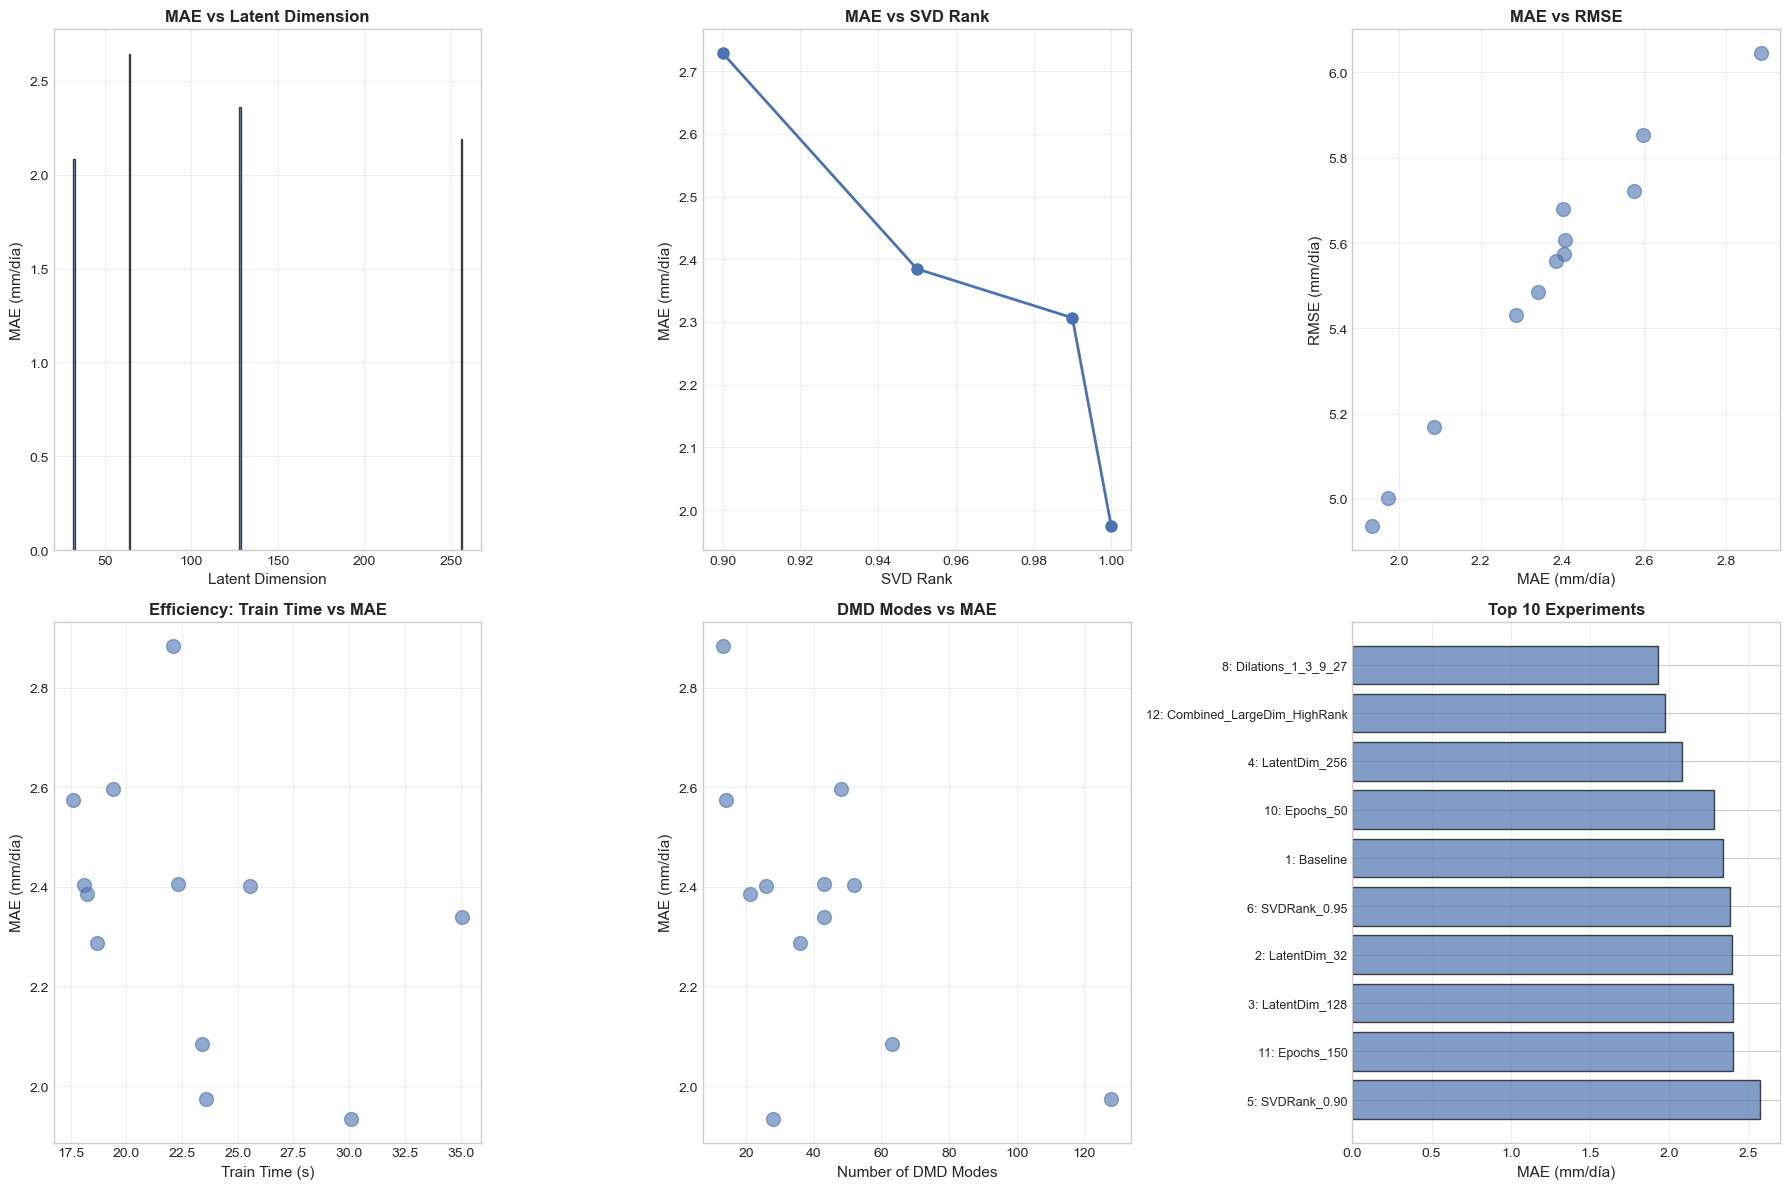

In [22]:
# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 1. MAE vs Latent Dim
latent_dims = df_results['latent_dim'].unique()
mae_by_latent = df_results.groupby('latent_dim')['mae'].mean()
axes[0].bar(latent_dims, mae_by_latent, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Latent Dimension', fontsize=11)
axes[0].set_ylabel('MAE (mm/día)', fontsize=11)
axes[0].set_title('MAE vs Latent Dimension', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. MAE vs SVD Rank
svd_ranks = sorted(df_results['svd_rank'].unique())
mae_by_svd = df_results.groupby('svd_rank')['mae'].mean()
axes[1].plot(svd_ranks, mae_by_svd, marker='o', linewidth=2, markersize=8)
axes[1].set_xlabel('SVD Rank', fontsize=11)
axes[1].set_ylabel('MAE (mm/día)', fontsize=11)
axes[1].set_title('MAE vs SVD Rank', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. MAE vs RMSE scatter
axes[2].scatter(df_results['mae'], df_results['rmse'], alpha=0.6, s=100)
axes[2].set_xlabel('MAE (mm/día)', fontsize=11)
axes[2].set_ylabel('RMSE (mm/día)', fontsize=11)
axes[2].set_title('MAE vs RMSE', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# 4. Train time vs MAE
axes[3].scatter(df_results['train_time'], df_results['mae'], alpha=0.6, s=100)
axes[3].set_xlabel('Train Time (s)', fontsize=11)
axes[3].set_ylabel('MAE (mm/día)', fontsize=11)
axes[3].set_title('Efficiency: Train Time vs MAE', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)

# 5. N Modes vs MAE
axes[4].scatter(df_results['n_modes'], df_results['mae'], alpha=0.6, s=100)
axes[4].set_xlabel('Number of DMD Modes', fontsize=11)
axes[4].set_ylabel('MAE (mm/día)', fontsize=11)
axes[4].set_title('DMD Modes vs MAE', fontsize=12, fontweight='bold')
axes[4].grid(True, alpha=0.3)

# 6. Top 10 experiments bar chart
top10 = df_results.head(10)
axes[5].barh(range(len(top10)), top10['mae'], alpha=0.7, edgecolor='black')
axes[5].set_yticks(range(len(top10)))
axes[5].set_yticklabels([f"{row.experiment_id}: {row.name}" for row in top10.itertuples()], fontsize=9)
axes[5].set_xlabel('MAE (mm/día)', fontsize=11)
axes[5].set_title('Top 10 Experiments', fontsize=12, fontweight='bold')
axes[5].invert_yaxis()
axes[5].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'hyperparameter_analysis.png'}")
plt.show()

---

## **Conclusiones**

Este notebook permite:

1. **Exploración sistemática** de hiperparámetros
2. **Comparación objetiva** de configuraciones
3. **Identificación de trade-offs** (performance vs tiempo)
4. **Selección de configuración óptima** para producción

**Próximos pasos:**
- Re-entrenar modelo óptimo con más épocas
- Validar configuración óptima en años 2019-2021
- Registrar mejor modelo en MLflow

**Nota**: Este notebook puede tardar 2-4 horas en ejecutarse completamente.